In [1]:
library(Seurat)
library(data.table)
library(stringr)
library(MAST)
library(ggplot2)
# library(monocle3)
library(dplyr)
library(rjson)

Attaching SeuratObject

Attaching sp

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs

In [2]:
fn = function(p, no.legend=T) {
    lx = unlist(lapply(p$patches$plots, function(x) {ggplot_build(x)$layout$panel_scales_x[[1]]$range$range}))
    ly = unlist(lapply(p$patches$plots, function(x) {ggplot_build(x)$layout$panel_scales_y[[1]]$range$range}))
    p = p & theme(panel.grid=element_line(colour="grey", size=0.5)) & xlim(min(lx), max(lx)) & ylim(min(ly), max(ly)) 
    if (no.legend) p = p & NoLegend()
    return(p)
}

# Load CARE-seq

In [3]:
path2root = "/work/magroup/tianming/Researches/sc-hic/data2/final"
path2figdir = file.path(path2root, 'figures-annotate-mBC')
print(path2figdir)

[1] "/work/magroup/tianming/Researches/sc-hic/data2/final/figures-annotate-mBC"


In [4]:
data <- Read10X(data.dir = file.path(path2root, "results", "RNA_mBC_complete_mm10_filtered_10x"))
obj <- CreateSeuratObject(counts = data, project = "mBC", min.cells = 10)
df_meta = read.csv(
    file.path(path2root, "results", "meta_mBC_complete_mm10_filtered.csv"), header = TRUE,
    row.name = 1, sep = ","
)
print(dim(df_meta))
stopifnot(all.equal(colnames(obj), rownames(df_meta)))
obj = AddMetaData(obj, df_meta)
obj[['dataset']] = 'CARE-seq'
obj[['dataset2']] = obj[['batch']]

obj[['doublet']] = do.call(rbind, lapply(c('mBC-0716-1', 'mBC-0716-2', 'mBC-0814-1'), function (lib) {
    df = read.csv(file.path(path2root, 'results', paste0('doublet_', lib, '_complete_mm10_filtered.csv')), row.names=1)
    rownames(df) = lapply(rownames(df), function (x) { paste0(lib, '_', x) })
    if (lib == 'mBC-0716-1') df = df['X1e.02_0.30']
    if (lib == 'mBC-0716-2') df = df['X1e.02_0.30']
    if (lib == 'mBC-0814-1') df = df['X1e.02_0.30']
    colnames(df) = c('doublet')
    df
}))

obj = subset(obj, subset=doublet == 0)

obj = subset(obj, subset=DNA.coverage.nnz500kb <= 4.5e4)

obj.care = obj
obj

[1] 4454  187


An object of class Seurat 
17019 features across 3296 samples within 1 assay 
Active assay: RNA (17019 features, 0 variable features)

In [82]:
data <- Read10X(data.dir = file.path(path2root, "results", "RNA_mBC_complete_mm10_filtered_10x"))
obj <- CreateSeuratObject(counts = data, project = "mBC", min.cells = 1)
obj <- obj[,colnames(obj.care)]
obj <- NormalizeData(obj, verbose=F)
obj <- ScaleData(obj, verbose=F)
obj.raw <- obj
obj

An object of class Seurat 
26419 features across 3296 samples within 1 assay 
Active assay: RNA (26419 features, 0 variable features)

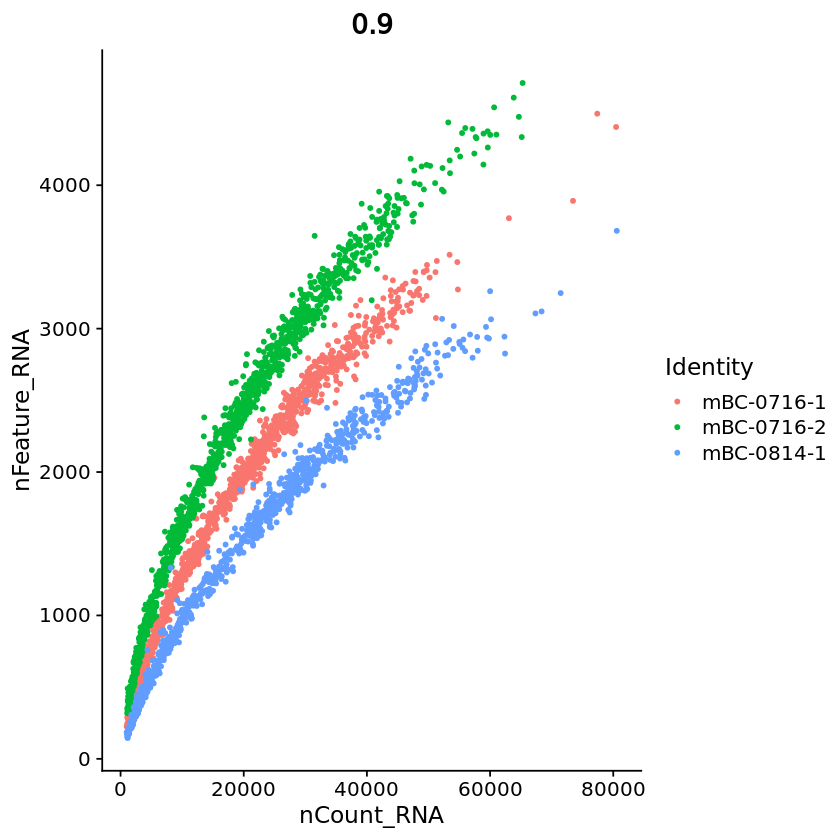

In [5]:
FeatureScatter(obj.care, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")

In [6]:
DefaultAssay(obj.care) <- "RNA"
obj.care <- NormalizeData(obj.care, verbose=F)
obj.care <- FindVariableFeatures(obj.care, verbose=F)
obj.care <- ScaleData(obj.care, verbose=F)
obj.care <- RunPCA(obj.care, verbose=F, npcs = 40)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


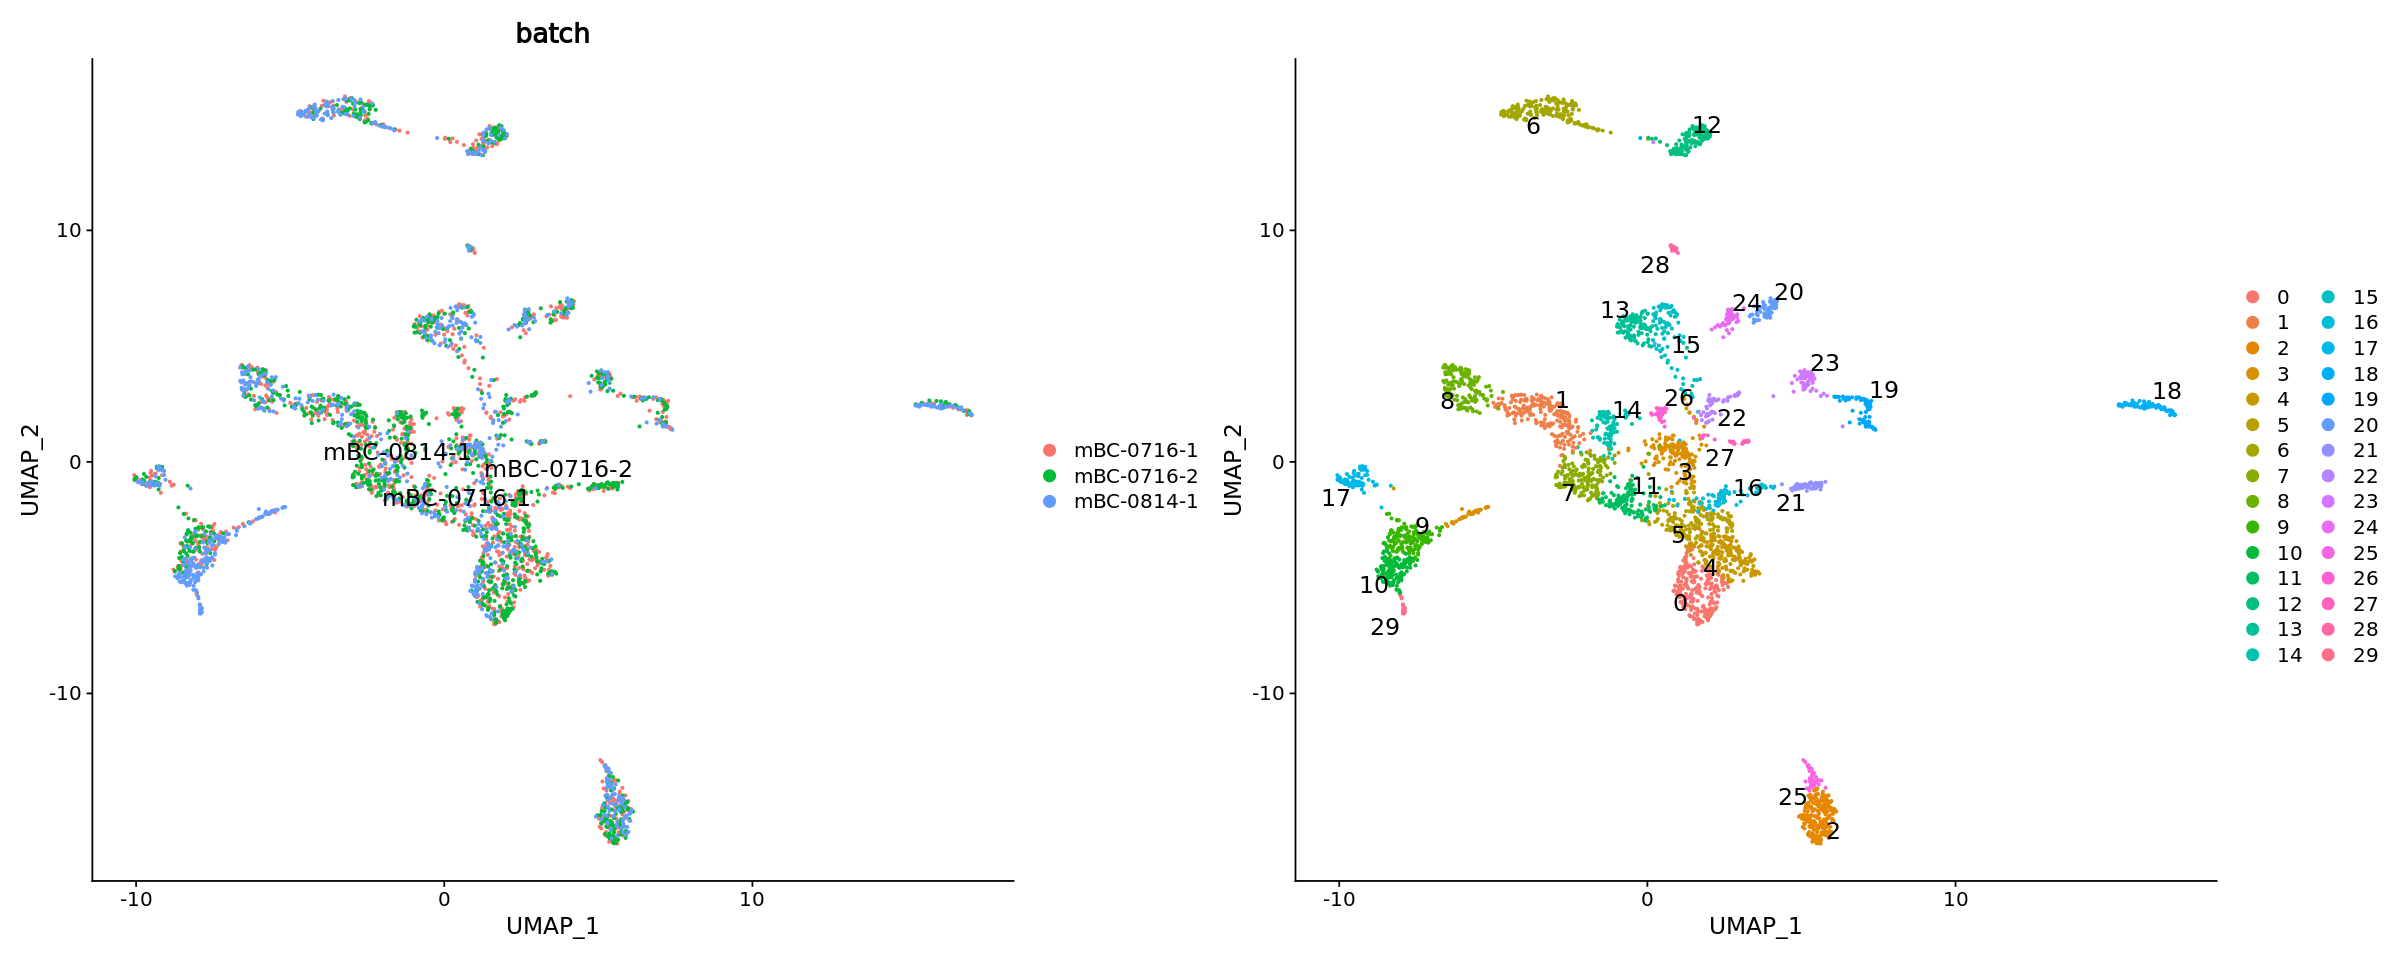

[1] "/work/magroup/tianming/Researches/sc-hic/data2/final/results/PCA_RNA-Seurat_mBC_complete_mm10_filtered.csv"
[1] "/work/magroup/tianming/Researches/sc-hic/data2/final/results/UMAP_RNA-Seurat_mBC_complete_mm10_filtered.csv"
[1] "/work/magroup/tianming/Researches/sc-hic/data2/final/results/meta-Seurat-raw_mBC_complete_mm10_filtered.csv"


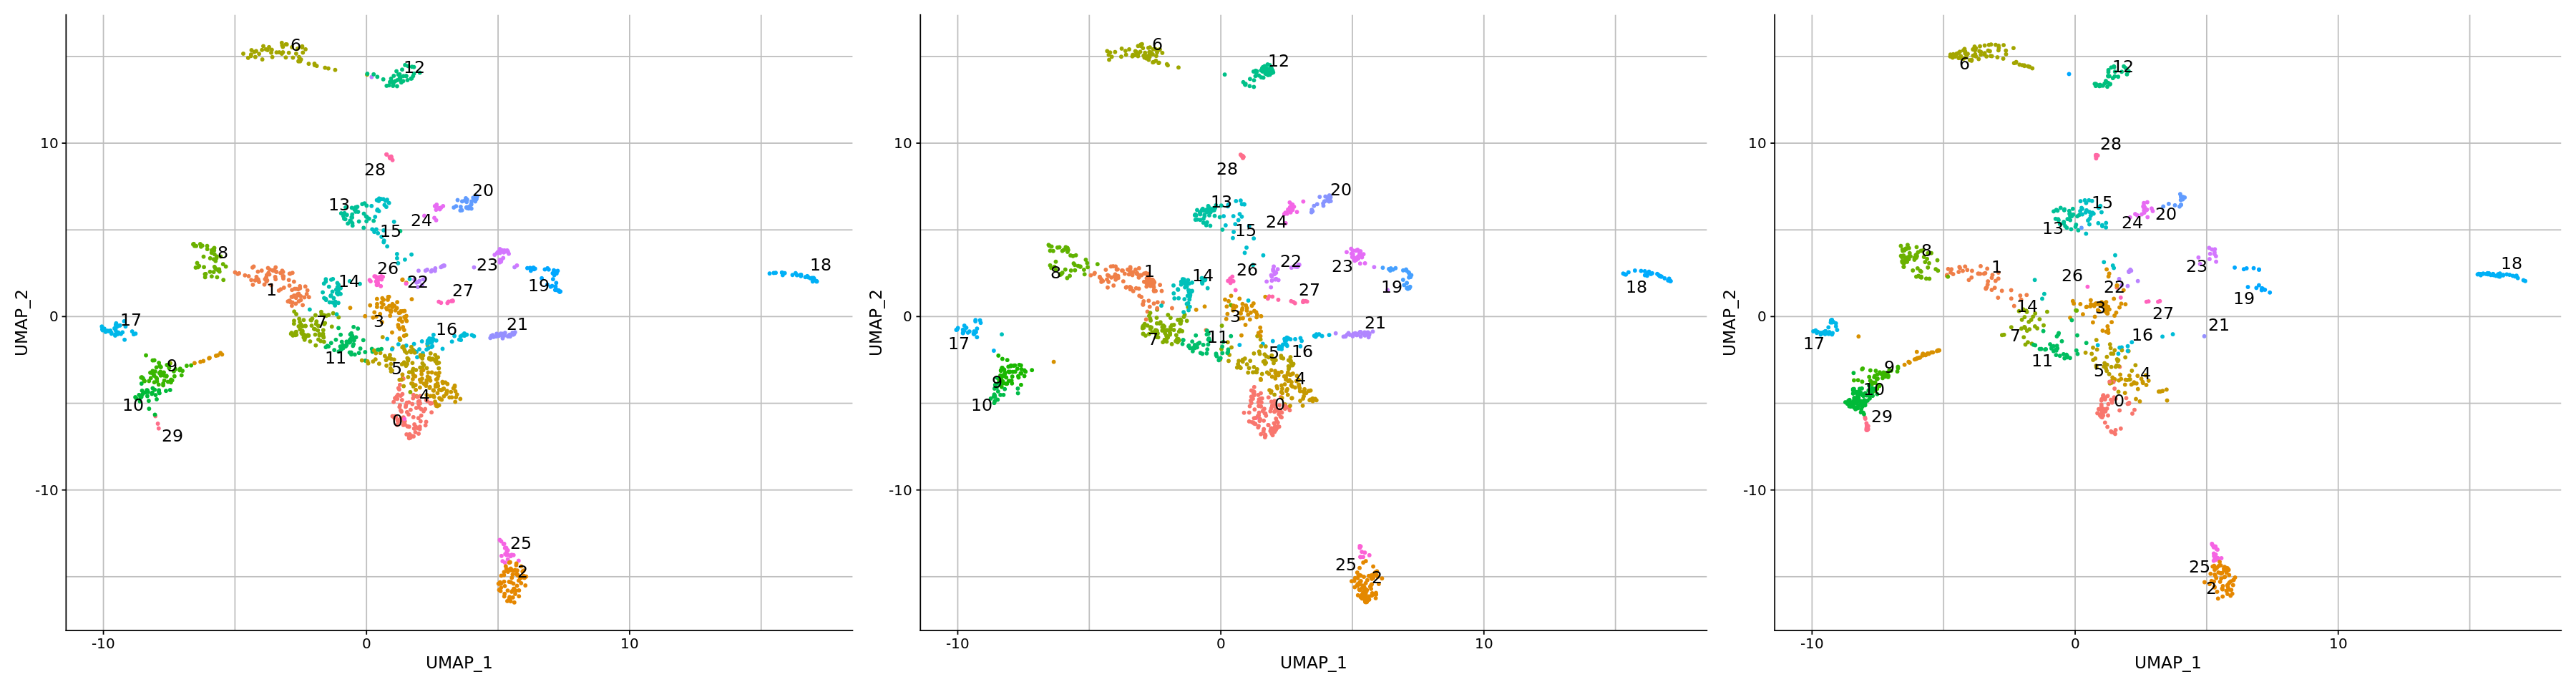

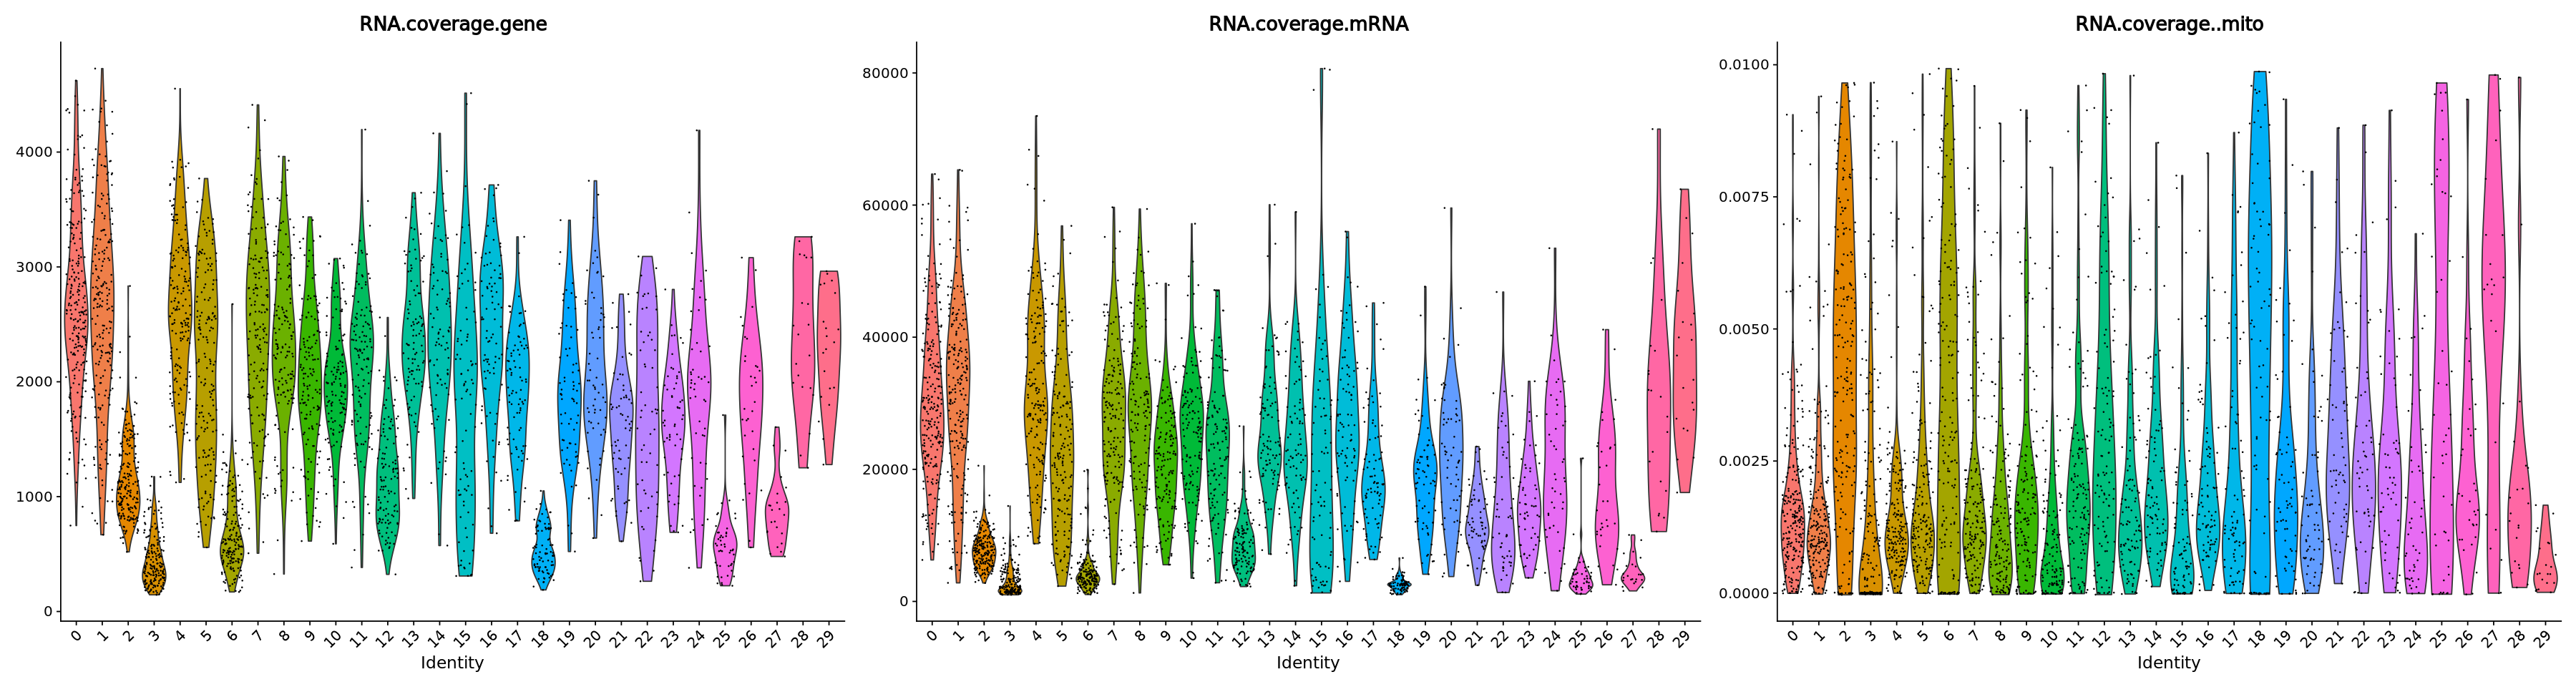

In [10]:
obj = obj.care

num_pcs = 27
num_nbrs = 20
obj <- FindNeighbors(
    obj, dims=1:num_pcs, k.param=num_nbrs, verbose=F,
    annoy.metric='euclidean'
)
obj <- FindClusters(obj, resolution=3, n.start=100, n.iter=100, verbose=F)
obj[['raw.ident']] <- Idents(obj)

obj <- RunUMAP(obj, verbose=F, dims=1:num_pcs, min.dist=.3, n.neighbors=num_nbrs, metric='euclidean')

saved <- options(repr.plot.width=20, repr.plot.height=8)
DimPlot(obj, label=T, repel=T, label.size=5, group.by='batch') +
DimPlot(obj, label=T, repel=T, label.size=5)
options(saved)
saved <- options(repr.plot.width=30, repr.plot.height=8)
fn(
    DimPlot(subset(obj, subset=batch=='mBC-0716-1'), label=T, repel=T, label.size=5) +
    DimPlot(subset(obj, subset=batch=='mBC-0716-2'), label=T, repel=T, label.size=5) +
    DimPlot(subset(obj, subset=batch=='mBC-0814-1'), label=T, repel=T, label.size=5)
)
options(saved)

path2file = file.path(path2root, "results", "PCA_RNA-Seurat_mBC_complete_mm10_filtered.csv")
print(path2file)
write.csv(data.frame(obj[["pca"]]@cell.embeddings), path2file)

path2file = file.path(path2root, "results", "UMAP_RNA-Seurat_mBC_complete_mm10_filtered.csv")
print(path2file)
write.csv(data.frame(obj[["umap"]]@cell.embeddings), path2file)

path2file = file.path(path2root, "results", "meta-Seurat-raw_mBC_complete_mm10_filtered.csv")
print(path2file)
write.csv(data.frame(Idents(obj)), path2file)

saved <- options(repr.plot.width=30, repr.plot.height=8)
print(VlnPlot(obj, c('RNA.coverage.gene', 'RNA.coverage.mRNA', 'RNA.coverage..mito')))
options(saved)

obj.care = obj

            Var1 Freq
1     L2 IT RvPP   63
2    L2/3 IT RSP   88
3  L2/3 IT CTX a  245
4  L2/3 IT CTX b  181
5  L2/3 IT CTX c  180
6      L4 IT CTX  128
7    L4/5 IT CTX  171
8      L5 IT RSP   89
9      L5 IT CTX  222
10     L6 IT CTX  151
11     L5 PT CTX   33
12   L6 CT CTX a  148
13   L6 CT CTX b  132
14   L5/6 NP CTX   86
15       L6b CTX   21
16       Pvalb a  100
17       Pvalb b   88
18         Sst a   64
19         Sst b   49
20           Vip   57
21          Sncg   21
22         Lamp5   72
23         Meis2   57
24         Astro  252
25           OPC  119
26           ODC  179
27          VLMC   24
28         Micro   85
29           Unk  191
[1] "/work/magroup/tianming/Researches/sc-hic/data2/final/results/meta-Seurat_mBC_complete_mm10_filtered.csv"


Warning message:
“ggrepel: 2 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


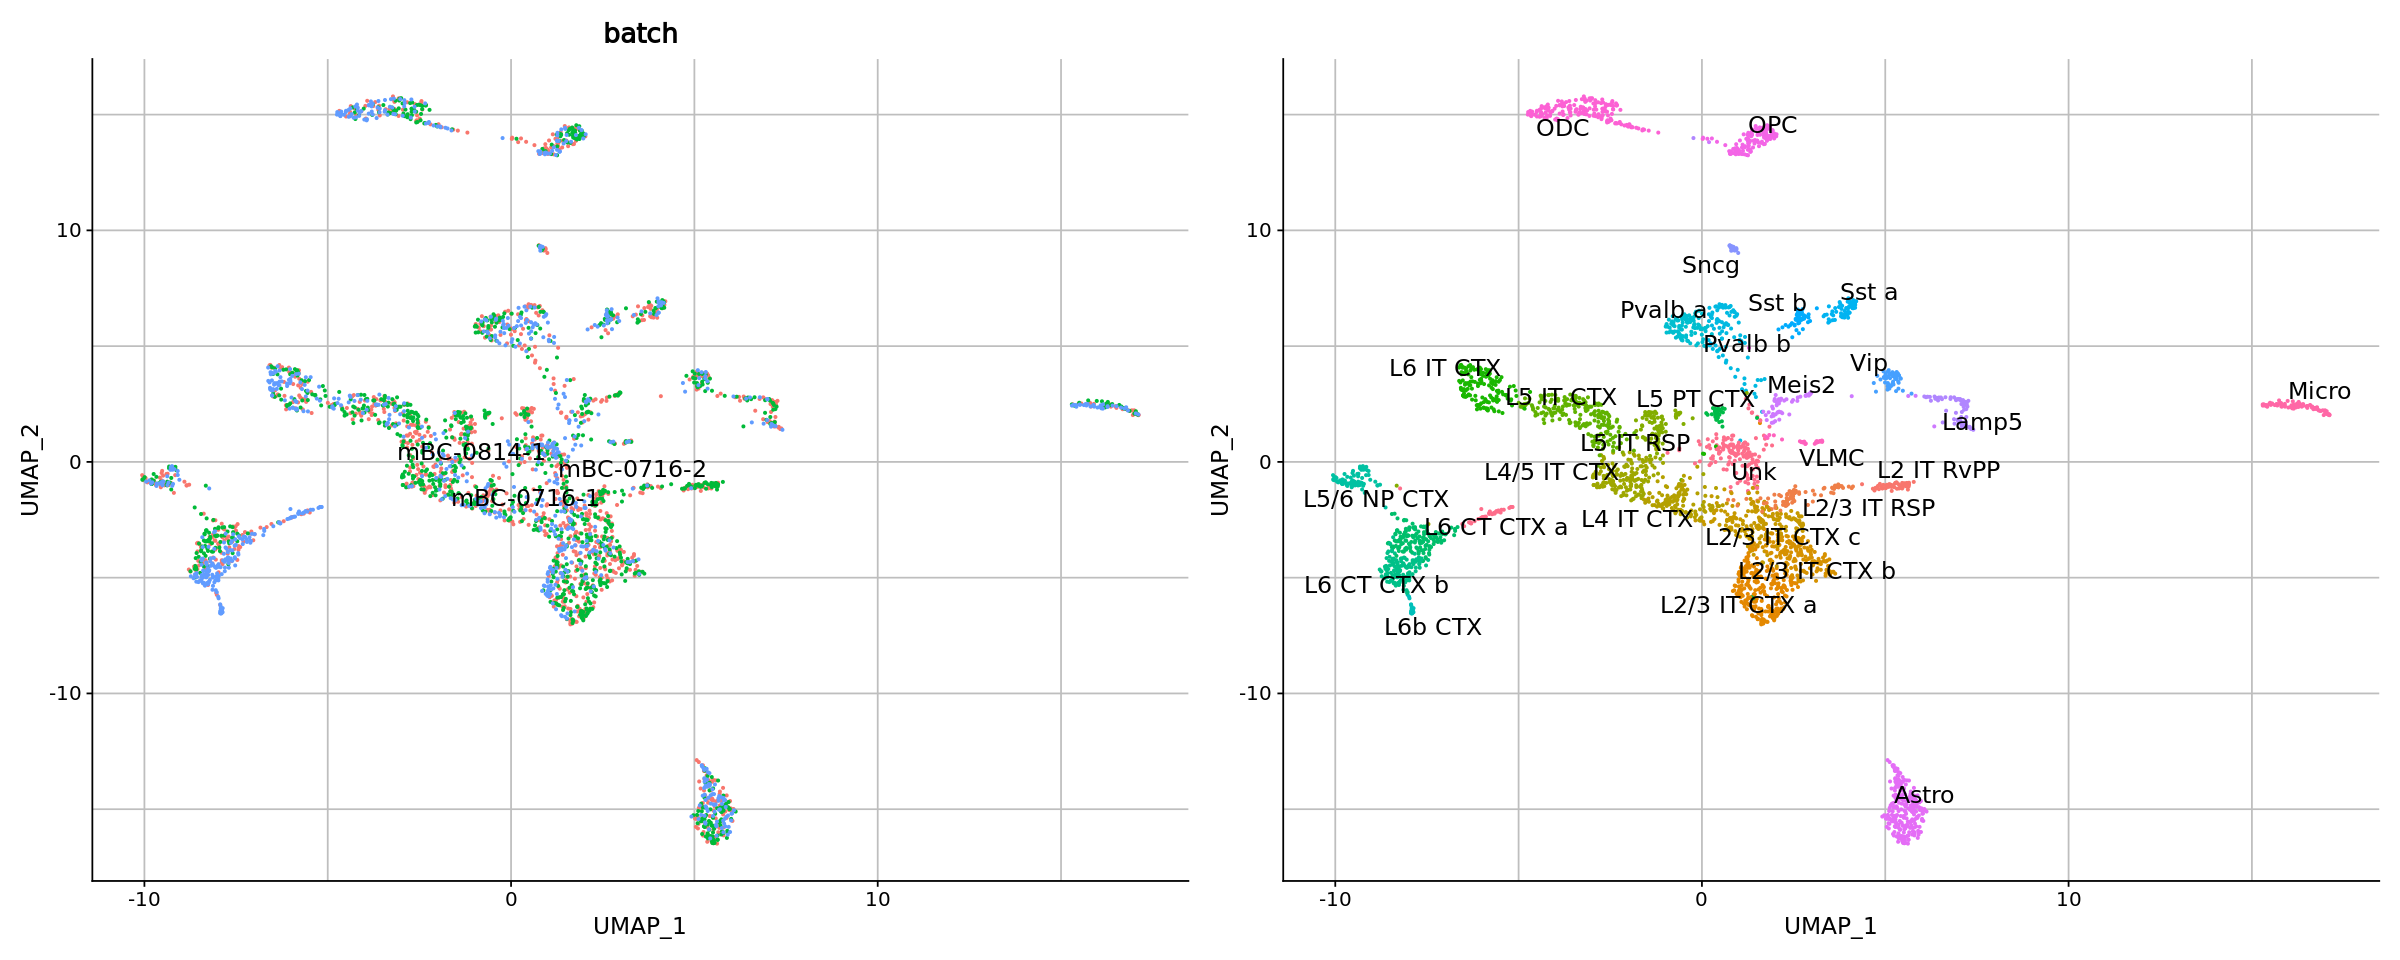

[1] "/work/magroup/tianming/Researches/sc-hic/data2/final/figures-annotate-mBC/annotation-umap.png"
[1] "/work/magroup/tianming/Researches/sc-hic/data2/final/figures-annotate-mBC/annotation-umap.pdf"


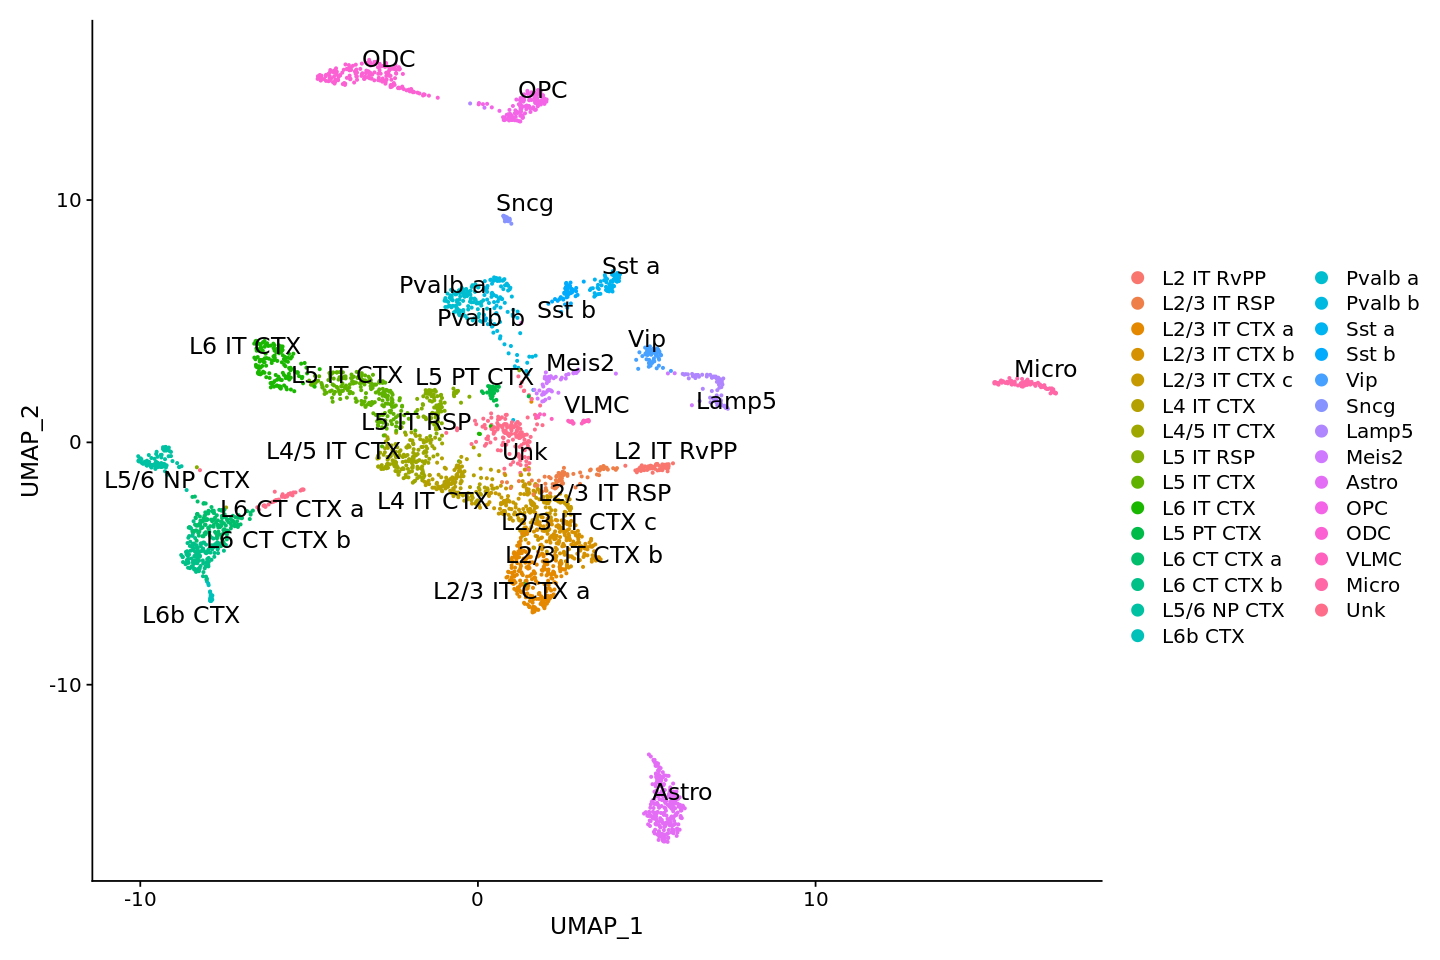

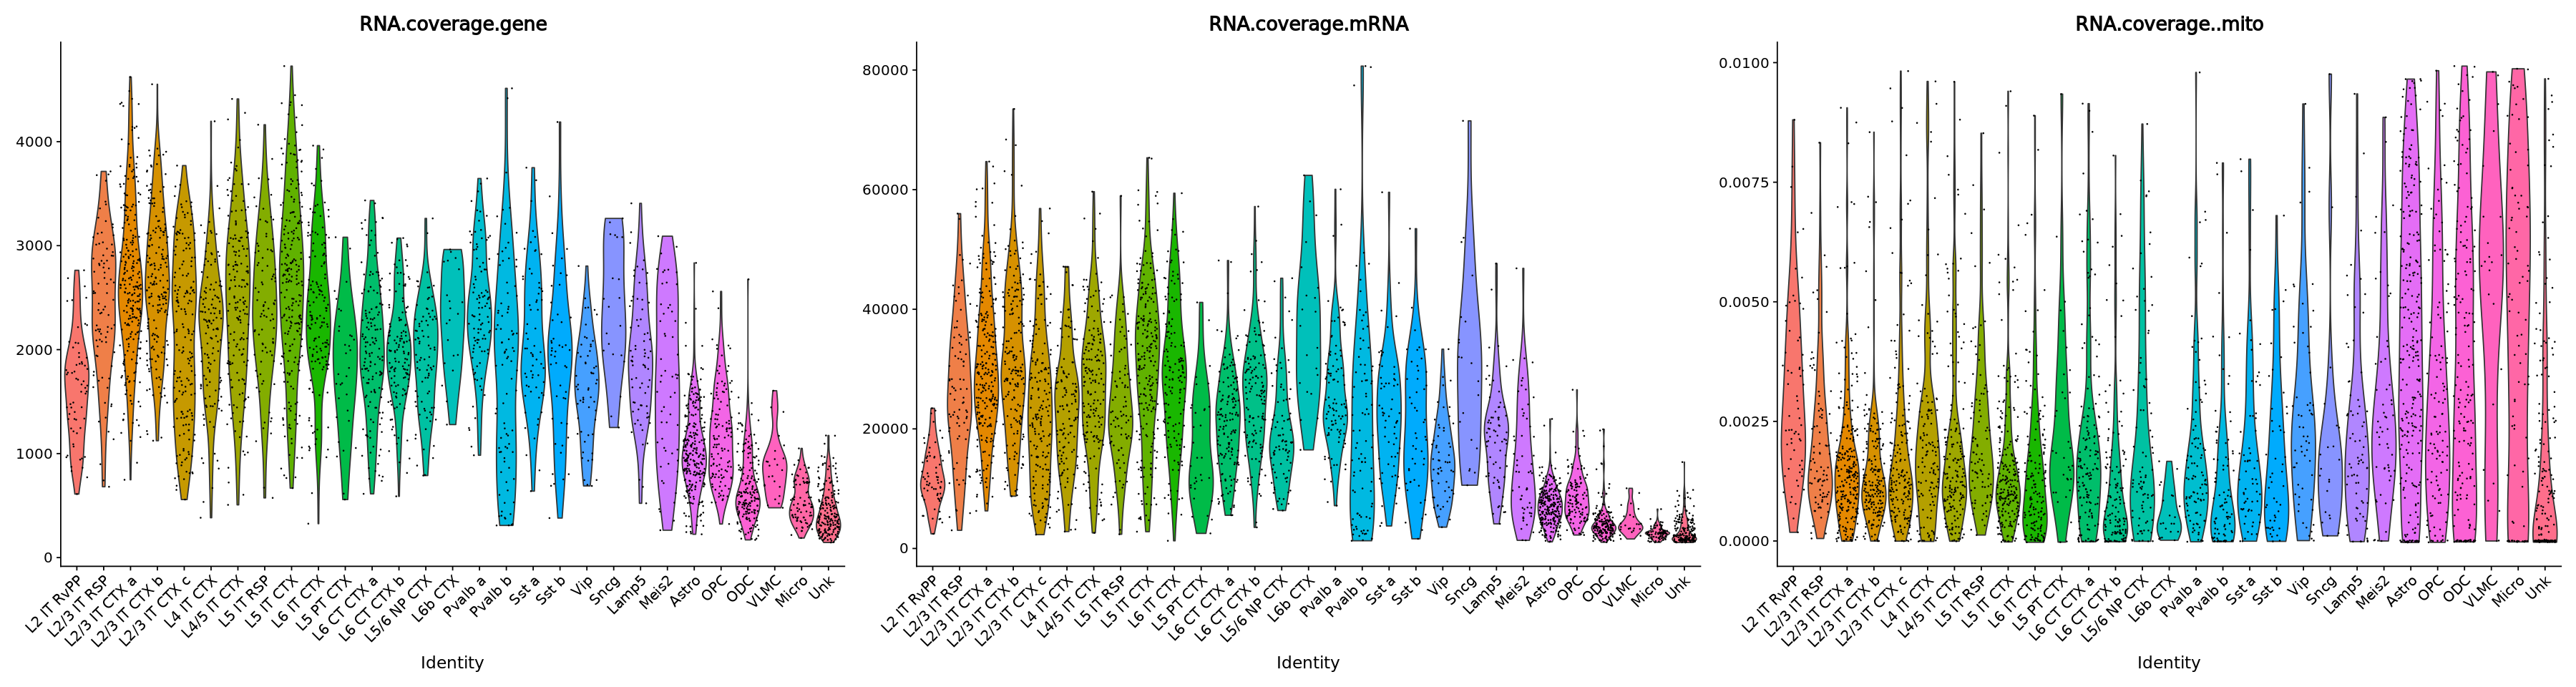

In [15]:
obj = obj.care
Idents(obj) = obj[['raw.ident']]
obj <- RenameIdents(object = obj, `21` = "L2 IT RvPP")
obj <- RenameIdents(object = obj, `16` = "L2/3 IT RSP")
obj <- RenameIdents(object = obj, `0`  = "L2/3 IT CTX a")
obj <- RenameIdents(object = obj, `4`  = "L2/3 IT CTX b")
obj <- RenameIdents(object = obj, `5`  = "L2/3 IT CTX c")
obj <- RenameIdents(object = obj, `11` = "L4 IT CTX")
obj <- RenameIdents(object = obj, `7`  = "L4/5 IT CTX")
obj <- RenameIdents(object = obj, `14` = "L5 IT RSP")
obj <- RenameIdents(object = obj, `1`  = "L5 IT CTX")
obj <- RenameIdents(object = obj, `8`  = "L6 IT CTX")
obj <- RenameIdents(object = obj, `26` = "L5 PT CTX")
obj <- RenameIdents(object = obj, `9`  = "L6 CT CTX a")
obj <- RenameIdents(object = obj, `10`  = "L6 CT CTX b")
obj <- RenameIdents(object = obj, `17` = "L5/6 NP CTX")
obj <- RenameIdents(object = obj, `29` = "L6b CTX")
obj <- RenameIdents(object = obj, `13` = "Pvalb a")
obj <- RenameIdents(object = obj, `15` = "Pvalb b")
obj <- RenameIdents(object = obj, `20` = "Sst a")
obj <- RenameIdents(object = obj, `24` = "Sst b")
obj <- RenameIdents(object = obj, `23` = "Vip")
obj <- RenameIdents(object = obj, `28` = "Sncg")
obj <- RenameIdents(object = obj, `19` = "Lamp5")
obj <- RenameIdents(object = obj, `22` = "Meis2")
obj <- RenameIdents(object = obj, `2` = "Astro")
obj <- RenameIdents(object = obj, `25` = "Astro")
obj <- RenameIdents(object = obj, `12`  = "OPC")
obj <- RenameIdents(object = obj, `6` = "ODC")
obj <- RenameIdents(object = obj, `27` = "VLMC")
obj <- RenameIdents(object = obj, `18` = "Micro")
obj <- RenameIdents(object = obj, `3` = "Unk")

Idents(obj) = factor(x=Idents(obj), levels=rev(levels(Idents(obj))))
print(data.frame(table(Idents(obj))))

path2file = file.path(path2root, "results", "meta-Seurat_mBC_complete_mm10_filtered.csv")
print(path2file)
write.csv(data.frame(Idents(obj)), path2file)

saved <- options(repr.plot.width=20, repr.plot.height=8)
p = fn(
    DimPlot(obj, label=T, repel=T, label.size=5, group.by='batch')+
    DimPlot(obj, label=T, repel=T, label.size=5))
print(p)
options(saved)

saved <- options(repr.plot.width=12, repr.plot.height=8)
p = DimPlot(obj, label=T, repel=T, label.size=5)
print(p)
options(saved)

saved <- options(repr.plot.width=30, repr.plot.height=8)
print(VlnPlot(obj, c('RNA.coverage.gene', 'RNA.coverage.mRNA', 'RNA.coverage..mito')))
options(saved)
obj.care = obj